In [1]:
%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .
%%capture
# For pip installation
!pip install speechbrain

In [2]:
import speechbrain as sb
import os
import pandas as pd
import torchaudio
import numpy as np
import soundfile
from speechbrain.inference.speaker import EncoderClassifier
from tqdm import tqdm
import pickle

/content/speechbrain/speechbrain/utils/torch_audio_backend.py:60: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered chec

In [3]:
!wget http://lsa.tmit.bme.hu/files/age-samples.zip
!unzip age-samples.zip
!ls

--2025-11-17 08:31:49--  http://lsa.tmit.bme.hu/files/age-samples.zip
Resolving lsa.tmit.bme.hu (lsa.tmit.bme.hu)... 152.66.246.99
Connecting to lsa.tmit.bme.hu (lsa.tmit.bme.hu)|152.66.246.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249657631 (238M) [application/x-zip-compressed]
Saving to: ‘age-samples.zip’

age-samples.zip     100%[===================>] 238.09M  11.1MB/s    in 50s     

2025-11-17 08:32:43 (4.71 MB/s) - ‘age-samples.zip’ saved [249657631/249657631]

Archive:  age-samples.zip
  inflating: 2021o6_meta_hc.csv      
  inflating: HC_001.wav              
  inflating: HC_002.wav              
  inflating: HC_003.wav              
  inflating: HC_004.wav              
  inflating: HC_0048_07_f.wav        
  inflating: HC_0049_06_f.wav        
  inflating: HC_005.wav              
  inflating: HC_0050_04_f.wav        
  inflating: HC_0051_03_f.wav        
  inflating: HC_0053_06_f.wav        
  inflating: HC_0054_02_f.wav        
  inflating:

In [4]:
dir = "/content/speechbrain/"
# read file list
files = os.listdir(dir)
print(files)

# read metadata
meta = pd.read_csv(dir + "/2021o6_meta_hc.csv",sep=";")
meta

['HE_H008_F_01.wav', 'HE_H011_F_01.wav', 'HC_55no.wav', 'tools', 'HC_026.wav', 'HC_61no.wav', 'HC_64no.wav', 'README.md', 'HC_46no.wav', 'HC_029.wav', 'HC_019.wav', 'HC_009.wav', '2021o6_meta_hc.csv', 'HC_038ffi.wav', 'HC_047affi.wav', 'HE_H013_F_01.wav', 'HC_0059_00_f.wav', 'HC_71no.wav', 'HC_0074_05_f.wav', 'HC_74no.wav', '.git', 'HC_27no.wav', 'HC_73no.wav', 'HC_015.wav', 'HC_034ffi.wav', 'HC_0085_00_m.wav', 'HC_042ffi.wav', 'HC_0080_08_f.wav', 'HC_011.wav', 'HE_H030_F_01.wav', 'HE_H001_F_01.wav', 'HC_50no.wav', 'HC_533no.wav', 'HE_H017_F_01.wav', 'HE_H014_F_01.wav', 'HC_48no.wav', 'tests', 'docs', 'HC_039ffi.wav', 'HC_08no.wav', 'HC_0082_02_m.wav', 'HC_001.wav', 'HC_028.wav', 'HC_72no.wav', 'HC_0122_03_m.wav', 'HC_040ffi.wav', 'HC_54no.wav', 'templates', 'HC_0089_06_m.wav', 'HC_0110_04_f.wav', 'HC_0067_03_m.wav', 'HC_267ffi.wav', 'HC_535no.wav', 'HE_H020_F_01.wav', 'HC_0088_07_m.wav', 'HC_0107_06_f.wav', '.pre-push-config.yaml', 'HC_0054_02_f.wav', 'HC_0076_09_m.wav', 'HC_62no.wav'

,sample,sex,age
0,HC_031ffi,male,51
1,HC_032ffi,male,60
2,HC_033ffi,male,52
3,HC_034ffi,male,44
4,HC_035ffi,male,25
...,...,...,...
221,HE_H029_F_01,female,67
222,HE_H030_F_01,male,75
223,HE_H031_F_01,male,76
224,HE_H032_F_01,female,77


In [5]:
# calculate embeddings
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", run_opts={"device":"cuda"})
signals = []
names = []
ages = []
sexes = []
embeddings = []
for _f in tqdm(files):
    meta_sel = meta[meta["sample"].str.lower() == _f.replace(".wav","").lower()]
    if len(meta_sel) > 0:
        ages.append(meta_sel.iloc[0]["age"])
        sexes.append(meta_sel.iloc[0]["sex"])
        names.append(_f)

        # calc emb
        signal, fs =torchaudio.load(dir + _f)
        embedding = classifier.encode_batch(signal)
        embeddings.append(np.array(embedding[0][0].cpu()))



INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


hyperparams.yaml: 0.00B [00:00, ?B/s]

/content/speechbrain/speechbrain/utils/torch_audio_backend.py:60: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  available_backends = torchaudio.list_audio_backends()
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
/content/speechbrain/speechbrain/utils/autocast.py:188: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  wrapped_fwd = torch.cuda.amp.

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["embedding_model"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/embedding_model.ckpt
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["mean_var_norm_emb"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/mean_var_norm_emb.ckpt
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["classifier"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/classifier.ckpt
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached


label_encoder.txt: 0.00B [00:00, ?B/s]

DEBUG:speechbrain.utils.parameter_transfer:Set local path in self.paths["label_encoder"] = /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/label_encoder.txt
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): embedding_model -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/embedding_model.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): mean_var_norm_emb -> /root/.cache/huggingface/hub/models--speechbrain--spkrec-xvect-voxceleb/snapshots/56895a2df401be4150a159f3a1c653f00051d477/mean_var_norm_emb.ckpt
DEBUG:speechbrain.utils.parameter_transfer:Redirecting (loading from local path): classifier -> /root/.cache/huggingface/hub/models--speechb

In [6]:
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn import svm
from sklearn.manifold import TSNE
loo = LeaveOneOut()
X = np.array(embeddings)
y = np.array(sexes)
loo.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVC(kernel = 'linear', probability=(False))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.append(y_test[0])
    pred.append(y_pred)

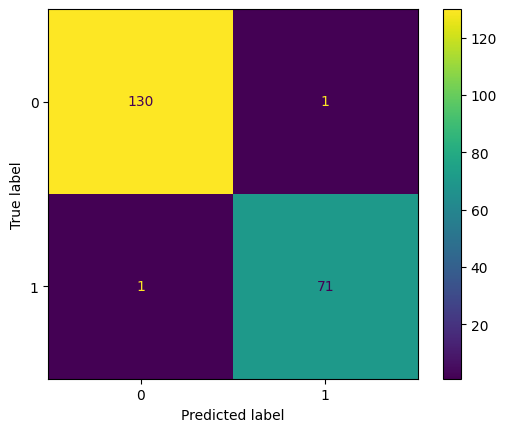

In [7]:
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(orig, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

rmse: 9.82684862101518
pearson: PearsonRResult(statistic=np.float64(0.8357815951018099), pvalue=np.float64(5.2585607583479035e-49))
spearman: SignificanceResult(statistic=np.float64(0.8447530371180275), pvalue=np.float64(5.009861404678625e-51))


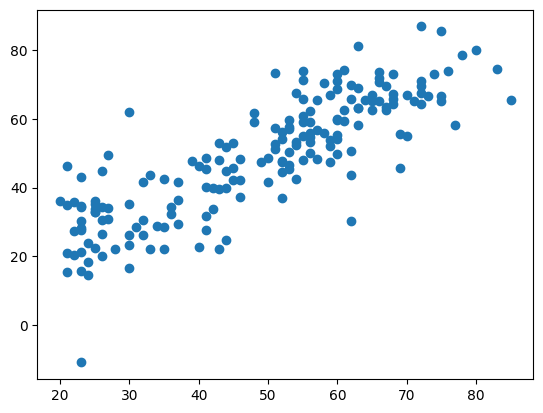

In [10]:
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import svm
from sklearn.manifold import TSNE
from scipy.stats import pearsonr, spearmanr
loo = LeaveOneOut()
kf = KFold(n_splits=10)
ages = np.array(ages)
X = np.array(embeddings)
X = X[ages!="-"]
y = ages[ages!="-"].astype(np.float16)
y = np.array(y)
loo.get_n_splits(X)
kf.get_n_splits(X)

orig = []
pred = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    clf = svm.SVR(kernel = 'linear')
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    orig.extend(y_test)
    pred.extend(y_pred)

from sklearn.metrics import root_mean_squared_error
plt.scatter(orig,pred)
print("rmse: " + str(root_mean_squared_error(orig,pred)))
print("pearson: " + str(pearsonr(orig,pred)))
print("spearman: " + str(spearmanr(orig,pred)))